In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from dust_extinction.averages import CT06_MWGC, RL85_MWGC, RRP89_MWGC, F11_MWGC, I05_MWAvg, CT06_MWLoc, G21_MWAvg
import regions
from regions import Regions
from astropy.nddata import Cutout2D
from astropy.table import Table, Column, MaskedColumn
from astropy import table


In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
import catalog_query as cq
from jwst_plots import make_cat_use, JWSTCatalog
from decaps_plots import DecapsCatalog, make_decaps_use
import cutout_manager as cm

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [5]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

# Decaps Catalog

In [6]:
pos = SkyCoord('17:46:20.8194569665', '-28:37:52.4236707380', unit=(u.hourangle, u.deg), frame='icrs')
size_filabox = (2.6762805138*u.arcmin, 86.6778672344*u.arcsec)
reg_filabox = regions.RectangleSkyRegion(center=pos, width=size_filabox[1], height=size_filabox[0])


In [7]:
im_filt_fn = f'{basepath}/images/jw02221-o002_t001_nircam_clear-f182m-merged-reproject-nodestreak_i2d-perfilt128.fits'
im_filt = fits.open(im_filt_fn)[0]

cutout_filt = Cutout2D(im_filt.data, position=pos, size=size_filabox, wcs=WCS(im_filt.header))

In [8]:
#decaps_fn = f'{basepath}/catalogs/decam_flux_l0.5b0.5.fits'
#decaps = Table.read(decaps_fn)
decaps_cat = make_decaps_use()
decaps = decaps_cat.catalog

In [9]:
decaps[:3]

ra,dec,posstdev,ra_ok,dec_ok,posstdev_ok,ndet,ndet_ok,nmag,nmag_ok,mean,stdev,err,median,q25,q75,ndet_cflux,ndet_cflux_ok,nmag_cflux,nmag_cflux_ok,mean_cflux,stdev_cflux,err_cflux,median_cflux,q25_cflux,q75_cflux,maglimit,epochrange,epochrange_ok,epochmean,epochmean_ok,dnt_all,dqflags_all,fracflux_avg,rchi2_avg,qf_avg,prn_avg,prl_avg,prr_avg,pre_avg,cchi2_avg,snr_avg,dnt_any,dqflags_any,_id,obj_id
float64,float64,float32,float64,float64,float32,int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float64,float64,float64,float64,int32[6],int64[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int32[6],int64[6],int64,int64
266.2567415536595,-28.00088999267355,0.09644666,266.2567415536595,-28.00088999267355,0.09644666,13,13,0 .. 6,0 .. 6,0.0 .. 7.745599e-09,0.0 .. 7.103565e-10,0.0 .. 2.915216e-10,0.0 .. 7.937175e-09,0.0 .. 7.470702e-09,0.0 .. 8.207482e-09,13,13,0 .. 6,0 .. 6,0.0 .. 7.721063e-09,0.0 .. 6.764225e-10,0.0 .. 3.8397127e-10,0.0 .. 7.899806e-09,0.0 .. 7.4203994e-09,0.0 .. 8.253182e-09,0.0 .. 21.365091,722.8257134000014,722.8257134000014,58007.49174939846,58007.49174939846,0 .. 0,0 .. 0,0.0 .. 0.73797244,0.0 .. 0.99717367,0.0 .. 1.0,0.0 .. 0.0072425976,0.0 .. 0.15577787,0.0 .. 0.81948566,0.0 .. 0.017493742,0.0 .. 642.2981,0.0 .. 11.832285,0 .. 0,0 .. 0,4900760819563323363,5098919203116720807
265.83302520143997,-28.117372138274987,0.10661936,265.83302520143997,-28.117372138274987,0.10661936,4,4,0 .. 1,0 .. 1,0.0 .. 4.5506e-09,0.0 .. 0.0,0.0 .. 5.9362093e-10,0.0 .. 4.5506e-09,0.0 .. 4.5506e-09,0.0 .. 4.5506e-09,4,4,0 .. 1,0 .. 1,0.0 .. 4.149399e-09,0.0 .. 0.0,0.0 .. 9.466654e-10,0.0 .. 4.149399e-09,0.0 .. 4.149399e-09,0.0 .. 4.149399e-09,0.0 .. 21.321514,7.946313680004096,7.946313680004096,57866.3707875,57866.3707875,0 .. 0,0 .. 0,0.0 .. 0.2327578,0.0 .. 0.9794993,0.0 .. 1.0,0.0 .. 1.42468e-07,0.0 .. 5.393787e-05,0.0 .. 0.9999417,0.0 .. 4.212124e-06,0.0 .. 306.5295,0.0 .. 7.685012,0 .. 0,0 .. 0,4900760819554427803,5062907998342584909
265.83339203653765,-28.210620476794347,0.26000202,265.83339203653765,-28.210620476794347,0.26000202,8,8,0 .. 6,0 .. 6,0.0 .. 9.415713e-09,0.0 .. 3.4364176e-09,0.0 .. 3.088686e-10,0.0 .. 9.191808e-09,0.0 .. 7.0025616e-09,0.0 .. 1.3008107e-08,8,8,0 .. 6,0 .. 6,0.0 .. 7.2793895e-09,0.0 .. 2.4252607e-09,0.0 .. 4.371212e-10,0.0 .. 7.600535e-09,0.0 .. 5.475495e-09,0.0 .. 9.61777e-09,0.0 .. 21.252556,469.5820205800046,469.5820205800046,58042.22434520375,58042.22434520375,0 .. 3,0 .. 0,0.0 .. 0.2962493,0.0 .. 2.1593347,0.0 .. 1.0000001,0.0 .. 3.6349946e-05,0.0 .. 0.0021282826,0.0 .. 0.99700207,0.0 .. 0.00083336624,0.0 .. 405.53812,0.0 .. 13.035642,0 .. 3,0 .. 0,4900760819554427802,5062907998342584907


In [10]:
decaps_dist_fn = '/orange/adamginsburg/cmz/decaps/decaps_galcen.fits'
decaps_dist = Table.read(decaps_dist_fn)
decaps_dist_coords = SkyCoord(decaps_dist['ra'], decaps_dist['dec'], unit=(u.deg, u.deg))
decaps_dist[:3]

decaps_id,ra,dec,dist,red,dred,eep,feh,loga,logg,logl,logt,mini
int64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5]
5206864856682159949,268.64097194033883,-28.254651460383855,0.5444698482751846 .. 14.843844723701476,3.5001443207263945 .. 5.324260103702545,3.0839701533317565 .. 3.3537982821464536,255.85000000000002 .. 662.0,-1.2499999999999993 .. 0.3512500000000012,8.840470076948325 .. 10.10286271107559,2.449192066276148 .. 4.806809487728728,-1.3591874538423145 .. 1.7487673547596394,3.573914244529528 .. 3.7196737108107,0.44999999999999996 .. 1.4749999999999996
5206864856682159952,268.6459733443047,-28.26505528280265,1.073886826634407 .. 18.768811178207393,2.687234127521515 .. 4.160738909244537,3.257476258277893 .. 3.4425309777259825,292.0 .. 520.0,-0.7512499999999989 .. 0.3500000000000023,9.11956621339885 .. 10.114302615641863,2.5095921788049473 .. 4.6786176693745025,-0.9572357419623658 .. 1.5920213104173957,3.619884549998221 .. 3.7537465019590623,0.575 .. 1.5499999999999996
5206882448868204619,268.639306415481,-28.247052171059337,4.760032260417939 .. 13.685214495658874,4.9255001783370975 .. 5.545442605018616,2.7539698421955108 .. 3.0149027705192566,514.0 .. 738.0,-0.3999999999999986 .. 0.40000000000000213,9.198834202106308 .. 10.111170673260702,1.7305351279517327 .. 2.6653053758668133,1.4044913346509749 .. 2.2732585183734253,3.6165912890969967 .. 3.6614178404899964,0.9249999999999998 .. 1.875624999999999


In [11]:
decaps_dist_fov = decaps_dist[reg_filabox.contains(decaps_dist_coords, WCS(im_filt.header))]
decaps_dist_fov[:3]

decaps_id,ra,dec,dist,red,dred,eep,feh,loga,logg,logl,logt,mini
int64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5]
5080852028046552594,266.5917498537868,-28.644843412224205,0.26411942914128306 .. 5.122766518592834,3.1025052428245545 .. 8.069432020187378,3.2848543226718903 .. 3.3574964821338655,226.0 .. 458.0,-0.6999999999999988 .. 0.3500000000000023,8.796778993402544 .. 10.002568047724612,3.67998258353583 .. 4.975792882905183,-2.275640038786349 .. 1.3629132934814505,3.461575441858873 .. 3.912063910518387,0.2 .. 1.8999999999999997
5080852028046552605,266.5774053092633,-28.651488021486742,1.2628842800855637 .. 12.318006110191343,4.415659773349762 .. 5.788400495052338,3.2542940258979796 .. 3.3700116634368897,304.0 .. 504.0,-1.4499999999999995 .. 0.2500000000000018,9.185420607743783 .. 10.118095211830223,2.9467840664890286 .. 4.649875078403791,-0.8240542459758943 .. 1.2916329974568561,3.6419380104054713 .. 3.810170603024147,0.6493749999999999 .. 1.5749999999999997
5080852028046552620,266.5925613156168,-28.64271359131861,0.9425268486142159 .. 17.963905954360957,5.722534120082855 .. 7.390837287902832,3.281995975971222 .. 3.3539639949798583,292.0 .. 658.05,-0.849999999999999 .. 0.3500000000000023,8.910840377716776 .. 10.072462713098671,2.4478719068299295 .. 4.675786024309525,-0.9739084364683225 .. 1.7070931518397794,3.6198249518705263 .. 3.85243126354575,0.575 .. 1.7499999999999996


In [12]:
decaps_catalog = SkyCoord(ra=decaps['ra']*u.deg, dec=decaps['dec']*u.deg)

# JWST Catalog

In [8]:
cat_use = make_cat_use()
crds_use = cat_use.catalog['skycoord_ref']

In [9]:
cutout_405 = cm.get_cutout_405(pos, size_filabox[0], size_filabox[1])
cutout_182 = cm.get_cutout_182(pos, size_filabox[0], size_filabox[1])

NameError: name 'pos' is not defined

In [ ]:
decaps_in = decaps[reg_filabox.contains(decaps_catalog, wcs=WCS(im_filt.header))]
decaps_catalog_in = SkyCoord(ra=decaps_in['ra']*u.deg, dec=decaps_in['dec']*u.deg)
decaps_cat_in = DecapsCatalog(decaps_in)

In [ ]:
reg_fov = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/f4_fov_cloudc.reg')
decaps_fov = decaps_cat.catalog[reg_fov[0].contains(decaps_catalog, wcs=WCS(im_filt.header))]
decaps_fov['skycoord'] = SkyCoord(ra=decaps_fov['ra']*u.deg, dec=decaps_fov['dec']*u.deg)
decaps_fov.write('/orange/adamginsburg/jwst/cloudc/catalogs/decaps_cloudc_fov.fits', overwrite=True)

In [ ]:
#decaps_fov['decaps_id'] = decaps_fov['obj_id']
decaps_fov[:3]

ra,dec,posstdev,ra_ok,dec_ok,posstdev_ok,ndet,ndet_ok,nmag,nmag_ok,mean,stdev,err,median,q25,q75,ndet_cflux,ndet_cflux_ok,nmag_cflux,nmag_cflux_ok,mean_cflux,stdev_cflux,err_cflux,median_cflux,q25_cflux,q75_cflux,maglimit,epochrange,epochrange_ok,epochmean,epochmean_ok,dnt_all,dqflags_all,fracflux_avg,rchi2_avg,qf_avg,prn_avg,prl_avg,prr_avg,pre_avg,cchi2_avg,snr_avg,dnt_any,dqflags_any,_id,obj_id,skycoord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
float64,float64,float32,float64,float64,float32,int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float64,float64,float64,float64,int32[6],int64[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int32[6],int64[6],int64,int64,SkyCoord
266.5817806756923,-28.573748311919985,0.12507114,266.5817806756923,-28.573748311919985,0.12507114,8,8,0 .. 1,0 .. 1,0.0 .. 3.5430443e-09,0.0 .. 0.0,0.0 .. 5.627807e-10,0.0 .. 3.5430443e-09,0.0 .. 3.5430443e-09,0.0 .. 3.5430443e-09,8,8,0 .. 1,0 .. 1,0.0 .. 3.5327863e-09,0.0 .. 0.0,0.0 .. 6.096158e-10,0.0 .. 3.5327863e-09,0.0 .. 3.5327863e-09,0.0 .. 3.5327863e-09,0.0 .. 21.378555,721.8225263900022,721.8225263900022,57894.29210361125,57894.29210361125,0 .. 0,0 .. 0,0.0 .. 0.96049553,0.0 .. 0.5308857,0.0 .. 1.0,0.0 .. 0.00038560072,0.0 .. 0.015681034,0.0 .. 0.98136526,0.0 .. 0.0025680466,0.0 .. 677.9327,0.0 .. 6.306214,0 .. 0,0 .. 0,4900479344558451254,5080852028060908612,"266.5817806756923,-28.573748311919985"
266.58585101835683,-28.61022880404579,0.068786755,266.5858502055778,-28.61022905503259,0.07348825,25,21,0 .. 5,0 .. 4,0.0 .. 3.125296e-08,0.0 .. 1.0792317e-09,0.0 .. 3.689589e-10,0.0 .. 3.1284294e-08,0.0 .. 3.0803683e-08,0.0 .. 3.179751e-08,25,21,0 .. 5,0 .. 4,0.0 .. 3.1438976e-08,0.0 .. 1.0219581e-09,0.0 .. 4.101206e-10,0.0 .. 3.1578352e-08,0.0 .. 3.108007e-08,0.0 .. 3.199318e-08,0.0 .. 21.270885,994.192959629996,994.192959629996,57955.1411873016,57972.19289353809,0 .. 0,0 .. 0,0.0 .. 0.9852497,0.0 .. 1.0458373,0.0 .. 0.99934286,0.0 .. 0.00016609601,0.0 .. 0.008107292,0.0 .. 0.99085486,0.0 .. 0.00087176624,0.0 .. 712.13,0.0 .. 46.411514,0 .. 0,0 .. 0,4900479344558430714,5080852028051394954,"266.58585101835683,-28.61022880404579"
266.5812351390935,-28.579478360538317,0.116672404,266.5812351390935,-28.579478360538317,0.116672404,6,6,0 .. 3,0 .. 3,0.0 .. 4.892151e-09,0.0 .. 1.6943033e-09,0.0 .. 4.0501527e-10,0.0 .. 4.6774296e-09,0.0 .. 4.4829624e-09,0.0 .. 6.880648e-09,6,6,0 .. 3,0 .. 3,0.0 .. 5.1095412e-09,0.0 .. 1.7588249e-09,0.0 .. 4.856828e-10,0.0 .. 4.838753e-09,0.0 .. 4.639954e-09,0.0 .. 6.970329e-09,0.0 .. 21.403732,723.8250177099981,723.8250177099981,57981.53845617667,57981.53845617667,0 .. 0,0 .. 0,0.0 .. 0.9999369,0.0 .. 0.88282895,0.0 .. 1.0,0.0 .. 0.00053337,0.0 .. 0.041018996,0.0 .. 0.95733756,0.0 .. 0.0011100376,0.0 .. 735.1788,0.0 .. 7.5923977,0 .. 0,0 .. 0,4900479344558451253,5080852028060908611,"266.5812351390935,-28.579478360538317"


In [ ]:
# Merge the decaps and basetable tables on the 'id_decaps' column
merged_table = table.join(decaps_fov, decaps_dist_fov, keys=['ra', 'dec'])#, keys=['decaps_id'])

decaps_fov = merged_table

# Display the first few rows of the merged table
merged_table[:3]



ra,dec,posstdev,ra_ok,dec_ok,posstdev_ok,ndet,ndet_ok,nmag,nmag_ok,mean,stdev,err,median,q25,q75,ndet_cflux,ndet_cflux_ok,nmag_cflux,nmag_cflux_ok,mean_cflux,stdev_cflux,err_cflux,median_cflux,q25_cflux,q75_cflux,maglimit,epochrange,epochrange_ok,epochmean,epochmean_ok,dnt_all,dqflags_all,fracflux_avg,rchi2_avg,qf_avg,prn_avg,prl_avg,prr_avg,pre_avg,cchi2_avg,snr_avg,dnt_any,dqflags_any,_id,obj_id,skycoord,decaps_id,dist,red,dred,eep,feh,loga,logg,logl,logt,mini
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,
float64,float64,float32,float64,float64,float32,int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float64,float64,float64,float64,int32[6],int64[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int32[6],int64[6],int64,int64,SkyCoord,int64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5]
266.57304957122085,-28.613210492420578,0.029161263,266.573048017309,-28.61321240927458,0.02774918,9,5,0 .. 3,0 .. 1,0.0 .. 5.806725e-08,0.0 .. 0.0,0.0 .. 8.907563e-10,0.0 .. 5.806725e-08,0.0 .. 5.806725e-08,0.0 .. 5.806725e-08,9,5,0 .. 3,0 .. 1,0.0 .. 5.8081994e-08,0.0 .. 0.0,0.0 .. 9.583836e-10,0.0 .. 5.8081994e-08,0.0 .. 5.8081994e-08,0.0 .. 5.8081994e-08,0.0 .. 21.120848,8.975714259999222,7.955320449997089,57866.707838916656,57867.577917840004,0 .. 0,0 .. 0,0.0 .. 0.99984074,0.0 .. 1.1097362,0.0 .. 1.0,0.0 .. 0.00433584,0.0 .. 0.06705026,0.0 .. 0.8969064,0.0 .. 0.03170756,0.0 .. 744.24506,0.0 .. 81.51555,0 .. 0,0 .. 0,4900479344558452814,5080852028068382180,"266.57304957122085,-28.613210492420578",5080852028046598290,0.12308394070714712 .. 4.512385630607594,7.028362619876861 .. 11.575794363021851,3.2516845524311067 .. 3.3752180993556977,232.0 .. 642.3499999999997,-1.5999999999999996 .. 0.2500000000000018,8.32097699800272 .. 9.918621039338944,2.90999894532371 .. 4.982852578007705,-2.1928046703039734 .. 1.916012597980261,3.4841225453801323 .. 3.940433911518301,0.225 .. 1.950624999999999
266.57350748163407,-28.644304352211392,0.08159423,266.57350758582913,-28.644304908383063,0.08275512,25,20,0 .. 6,0 .. 5,0.0 .. 2.1547216e-08,0.0 .. 1.2560373e-09,0.0 .. 4.4443935e-10,0.0 .. 2.1818966e-08,0.0 .. 2.0852399e-08,0.0 .. 2.2283045e-08,25,20,0 .. 6,0 .. 5,0.0 .. 2.1505265e-08,0.0 .. 1.3730815e-09,0.0 .. 5.090094e-10,0.0 .. 2.1707294e-08,0.0 .. 2.0995564e-08,0.0 .. 2.196572e-08,0.0 .. 21.271713,994.1916069500003,740.9335693999965,58158.191162086,58220.876354772,0 .. 0,0 .. 0,0.0 .. 0.99769163,0.0 .. 0.77999216,0.0 .. 1.0,0.0 .. 0.0010098236,0.0 .. 0.03728601,0.0 .. 0.9566135,0.0 .. 0.00509061,0.0 .. 702.30365,0.0 .. 26.142288,0 .. 0,0 .. 0,4900479344558436295,5080852028051424006,"266.57350748163407,-28.644304352211392",5080852028046598305,1.5308830440044403 .. 13.491135334968565,5.197808706760407 .. 6.63289167881012,3.28066948056221 .. 3.3482544302940367,297.85 .. 502.04999999999995,-1.3512499999999994 .. 0.2500000000000018,8.71195446508484 .. 10.078151006259631,2.971441620272652 .. 4.634589481138352,-0.6568379761075087 .. 1.359203470858217,3.66607810141979 .. 3.896539810017454,0.699375 .. 1.7756249999999991
266.5735739276041,-28.622124201098146,0.08413767,266.57357419537885,-28.622127932499993,0.06536021,38,29,0 .. 7,0 .. 5,0.0 .. 1.0510228e-07,0.0 .. 1.7923485e-09,0.0 .. 7.0179224e-10,0.0 .. 1.0463012e-07,0.0 .. 1.0431849e-07,0.0 .. 1.07087104e-07,38,29,0 .. 7,0 .. 5,0.0 .. 1.04954005e-07,0.0 .. 1.6509616e-09,0.0 .. 7.7152573e-10,0.0 .. 1.046465e-07,0.0 .. 1.0439109e-07,0.0 .. 1.07127775e-07,0.0 .. 20.962376,741.9532866000009,740.9335693999965,58154.42099534656,58195.032066841035,0 .. 0,0 .. 0,0.0 .. 0.94690466,0.0 .. 1.3427418,0.0 .. 0.99999994,0.0 .. 0.0011903242,0.0 .. 0.024679527,0.0 .. 0.96590364,0.0 .. 0.008226548,0.0 .. 602.96985,0.0 .. 92.34726,0 .. 0,0 .. 

# Plot Decaps Positions

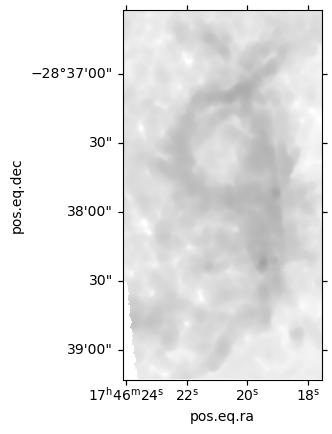

In [16]:
ax = plt.subplot(111, projection=cutout_filt.wcs)
ax.imshow(cutout_filt.data, origin='lower', cmap='gray', norm=simple_norm(cutout_filt.data, stretch='log', max_percent=99.9))

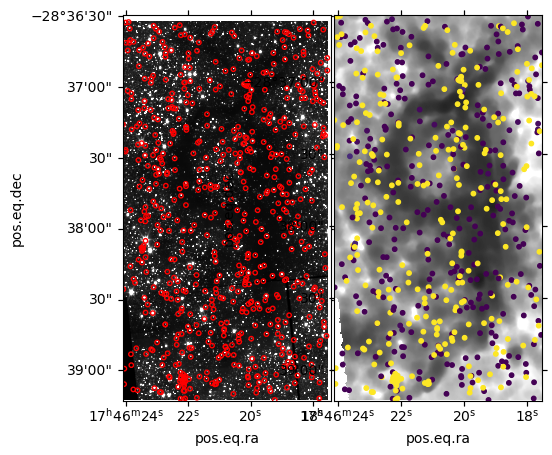

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection=cutout_182.wcs)
ax.imshow(cutout_182.data, origin='lower', cmap='gray', vmin=0, vmax=50)#, norm=simple_norm(cutout_405.data, percent=99))
ax.scatter(decaps_catalog_in.ra, decaps_catalog_in.dec, s=10, transform=ax.get_transform('world'), edgecolor='red', facecolor='none')

ax2 = plt.subplot(122, projection=cutout_filt.wcs, sharex=ax, sharey=ax)
ax2.imshow(cutout_filt.data, origin='lower', cmap='gray', vmin=0, vmax=5)
im = ax2.scatter(decaps_catalog_in.ra, decaps_catalog_in.dec, s=10, transform=ax2.get_transform('world'), cmap='viridis_r', c=decaps_cat_in.qf('i'))#, edgecolor='black')
#plt.colorbar(im, ax=(ax, ax2), label='Distance (pc)')

#plt.tight_layout()

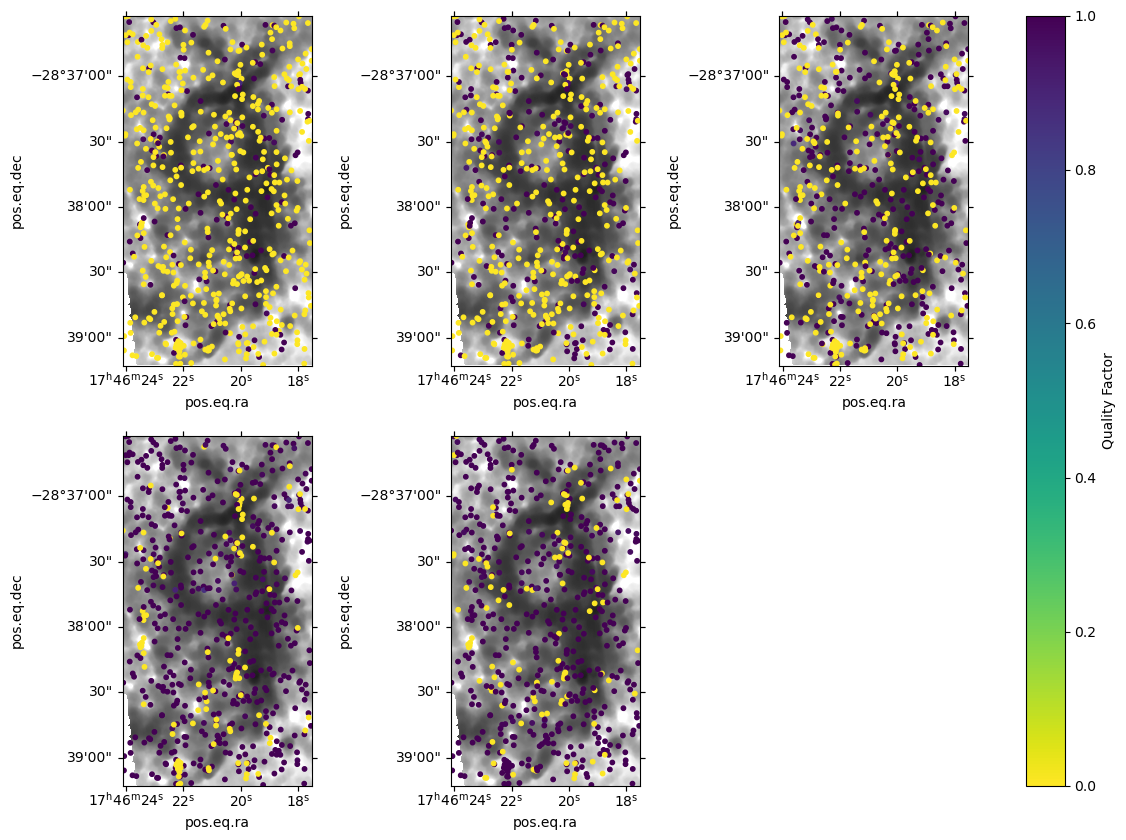

In [18]:
# ['g', 'r', 'i', 'z', 'y']

fig = plt.figure(figsize=(15, 10))

ax1 = plt.subplot(231, projection=cutout_filt.wcs)
ax1.imshow(cutout_filt.data, origin='lower', cmap='gray', vmin=0, vmax=5)
ax1.scatter(decaps_catalog_in.ra, decaps_catalog_in.dec, s=10, transform=ax1.get_transform('world'), c=decaps_cat_in.qf('g'), cmap='viridis_r', vmin=0, vmax=1)

ax2 = plt.subplot(232, projection=cutout_filt.wcs, sharex=ax1, sharey=ax1)
ax2.imshow(cutout_filt.data, origin='lower', cmap='gray', vmin=0, vmax=5)
ax2.scatter(decaps_catalog_in.ra, decaps_catalog_in.dec, s=10, transform=ax2.get_transform('world'), c=decaps_cat_in.qf('r'), cmap='viridis_r', vmin=0, vmax=1)

ax3 = plt.subplot(233, projection=cutout_filt.wcs, sharex=ax1, sharey=ax1)
ax3.imshow(cutout_filt.data, origin='lower', cmap='gray', vmin=0, vmax=5)
ax3.scatter(decaps_catalog_in.ra, decaps_catalog_in.dec, s=10, transform=ax3.get_transform('world'), c=decaps_cat_in.qf('i'), cmap='viridis_r', vmin=0, vmax=1)

ax4 = plt.subplot(234, projection=cutout_filt.wcs, sharex=ax1, sharey=ax1)
ax4.imshow(cutout_filt.data, origin='lower', cmap='gray', vmin=0, vmax=5)
ax4.scatter(decaps_catalog_in.ra, decaps_catalog_in.dec, s=10, transform=ax4.get_transform('world'), c=decaps_cat_in.qf('z'), cmap='viridis_r', vmin=0, vmax=1)

ax5 = plt.subplot(235, projection=cutout_filt.wcs, sharex=ax1, sharey=ax1)
ax5.imshow(cutout_filt.data, origin='lower', cmap='gray', vmin=0, vmax=5)
im = ax5.scatter(decaps_catalog_in.ra, decaps_catalog_in.dec, s=10, transform=ax5.get_transform('world'), c=decaps_cat_in.qf('y'), cmap='viridis_r', vmin=0, vmax=1)

plt.colorbar(im, ax=(ax1, ax2, ax3, ax4, ax5), label='Quality Factor')

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Axes: xlabel='G - R', ylabel='G'>

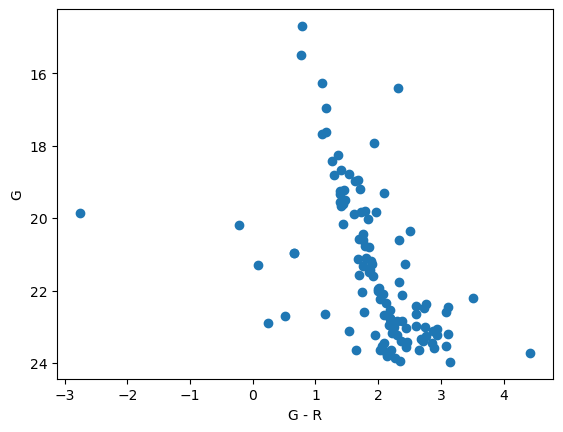

In [19]:
ax = plt.subplot(111)
decaps_cat_in.plot_CMD('g', 'r', 'g', ax=ax)

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Axes: xlabel='Z - Y', ylabel='Z'>

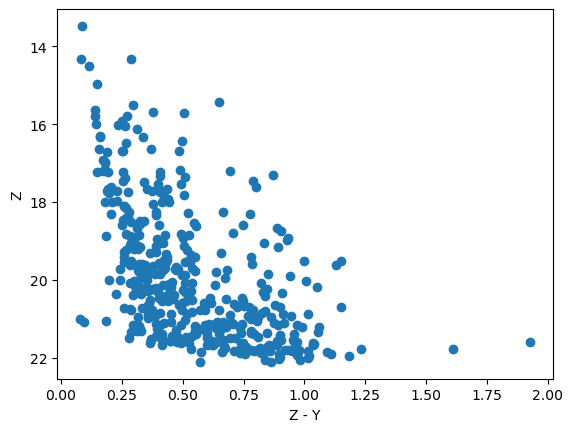

In [20]:
ax = plt.subplot(111)
decaps_cat_in.plot_CMD('z', 'y', 'z', ax=ax)

In [21]:
decaps_fov[:3]

ra,dec,posstdev,ra_ok,dec_ok,posstdev_ok,ndet,ndet_ok,nmag,nmag_ok,mean,stdev,err,median,q25,q75,ndet_cflux,ndet_cflux_ok,nmag_cflux,nmag_cflux_ok,mean_cflux,stdev_cflux,err_cflux,median_cflux,q25_cflux,q75_cflux,maglimit,epochrange,epochrange_ok,epochmean,epochmean_ok,dnt_all,dqflags_all,fracflux_avg,rchi2_avg,qf_avg,prn_avg,prl_avg,prr_avg,pre_avg,cchi2_avg,snr_avg,dnt_any,dqflags_any,_id,obj_id,skycoord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
float64,float64,float32,float64,float64,float32,int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float64,float64,float64,float64,int32[6],int64[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int32[6],int64[6],int64,int64,SkyCoord
266.5817806756923,-28.573748311919985,0.12507114,266.5817806756923,-28.573748311919985,0.12507114,8,8,0 .. 1,0 .. 1,0.0 .. 3.5430443e-09,0.0 .. 0.0,0.0 .. 5.627807e-10,0.0 .. 3.5430443e-09,0.0 .. 3.5430443e-09,0.0 .. 3.5430443e-09,8,8,0 .. 1,0 .. 1,0.0 .. 3.5327863e-09,0.0 .. 0.0,0.0 .. 6.096158e-10,0.0 .. 3.5327863e-09,0.0 .. 3.5327863e-09,0.0 .. 3.5327863e-09,0.0 .. 21.378555,721.8225263900022,721.8225263900022,57894.29210361125,57894.29210361125,0 .. 0,0 .. 0,0.0 .. 0.96049553,0.0 .. 0.5308857,0.0 .. 1.0,0.0 .. 0.00038560072,0.0 .. 0.015681034,0.0 .. 0.98136526,0.0 .. 0.0025680466,0.0 .. 677.9327,0.0 .. 6.306214,0 .. 0,0 .. 0,4900479344558451254,5080852028060908612,"266.5817806756923,-28.573748311919985"
266.58585101835683,-28.61022880404579,0.068786755,266.5858502055778,-28.61022905503259,0.07348825,25,21,0 .. 5,0 .. 4,0.0 .. 3.125296e-08,0.0 .. 1.0792317e-09,0.0 .. 3.689589e-10,0.0 .. 3.1284294e-08,0.0 .. 3.0803683e-08,0.0 .. 3.179751e-08,25,21,0 .. 5,0 .. 4,0.0 .. 3.1438976e-08,0.0 .. 1.0219581e-09,0.0 .. 4.101206e-10,0.0 .. 3.1578352e-08,0.0 .. 3.108007e-08,0.0 .. 3.199318e-08,0.0 .. 21.270885,994.192959629996,994.192959629996,57955.1411873016,57972.19289353809,0 .. 0,0 .. 0,0.0 .. 0.9852497,0.0 .. 1.0458373,0.0 .. 0.99934286,0.0 .. 0.00016609601,0.0 .. 0.008107292,0.0 .. 0.99085486,0.0 .. 0.00087176624,0.0 .. 712.13,0.0 .. 46.411514,0 .. 0,0 .. 0,4900479344558430714,5080852028051394954,"266.58585101835683,-28.61022880404579"
266.5812351390935,-28.579478360538317,0.116672404,266.5812351390935,-28.579478360538317,0.116672404,6,6,0 .. 3,0 .. 3,0.0 .. 4.892151e-09,0.0 .. 1.6943033e-09,0.0 .. 4.0501527e-10,0.0 .. 4.6774296e-09,0.0 .. 4.4829624e-09,0.0 .. 6.880648e-09,6,6,0 .. 3,0 .. 3,0.0 .. 5.1095412e-09,0.0 .. 1.7588249e-09,0.0 .. 4.856828e-10,0.0 .. 4.838753e-09,0.0 .. 4.639954e-09,0.0 .. 6.970329e-09,0.0 .. 21.403732,723.8250177099981,723.8250177099981,57981.53845617667,57981.53845617667,0 .. 0,0 .. 0,0.0 .. 0.9999369,0.0 .. 0.88282895,0.0 .. 1.0,0.0 .. 0.00053337,0.0 .. 0.041018996,0.0 .. 0.95733756,0.0 .. 0.0011100376,0.0 .. 735.1788,0.0 .. 7.5923977,0 .. 0,0 .. 0,4900479344558451253,5080852028060908611,"266.5812351390935,-28.579478360538317"


# Merge JWST Catalog with Decaps

In [85]:
# Build basecrds, which should have ALL the coords
basecrds = SkyCoord(ra=cat_use.catalog['skycoord_ref'].ra, dec=cat_use.catalog['skycoord_ref'].dec)
crds = SkyCoord(ra=decaps_fov['ra']*u.deg, dec=decaps_fov['dec']*u.deg)

matches, sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)
reverse_matches, reverse_sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)

mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))
max_offset = 0.1*u.arcsec
newcrds = crds[(sep > max_offset) & (~mutual_matches)]
basecrds = SkyCoord([basecrds,newcrds])

print('Base coord length = ', len(basecrds))
print('Added new sources = ', len(newcrds)) 

Base coord length =  131300
Added new sources =  0


In [86]:
# Build the basetable, which should have ALL of the columns and combine the two tables
basetable = Table()
basetable['skycoord_ref'] = basecrds

crds = SkyCoord(ra=decaps_fov['ra']*u.deg, dec=decaps_fov['dec']*u.deg)
matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
reverse_matches, reverse_sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)

mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))

wl = 'decaps'

print(f'{wl} has ', len(decaps_fov), ' sources. ', mutual_matches.sum(), ' mutual matches found.')

basetable.add_column(name=f"sep_{wl}", col=sep)
basetable.add_column(name=f"id_{wl}", col=matches)
matchtb = decaps_fov[matches]
badsep = sep > max_offset

#for cn in matchtb.colnames:
#    if isinstance(matchtb[cn], SkyCoord):
#        matchtb.rename_column(cn, f"{wl}_{cn}")
#        matchtb[f'mask_{wl}'] = badsep
#    else: 
#        matchtb[f'{cn}_{wl}'] = MaskedColumn(data=matchtb[cn], name=f'{cn}_{wl}')
#        matchtb[f'{cn}_{wl}'].mask[badsep] = True
#        # mask non-mutual matches
#        matchtb[f'{cn}_{wl}'].mask[~mutual_matches] = True
#        if hasattr(matchtb[cn], 'meta'):
#            matchtb[f'{cn}_{wl}'].meta = matchtb[cn].meta
#        matchtb.remove_column(cn)
matchtb[f'mask_{wl}'] = badsep

crds = SkyCoord(ra=cat_use.catalog['skycoord_ref'].ra, dec=cat_use.catalog['skycoord_ref'].dec)
matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
reverse_matches, reverse_sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)

mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))

reverse_matchtb = cat_use.catalog[matches]
reverse_matchtb.rename_column('skycoord_ref', f'skycoord_jwst')

basetable = table.hstack([basetable, matchtb, reverse_matchtb], join_type='exact')

decaps has  164  sources.  164  mutual matches found.


In [87]:
basetable[:3]

skycoord_ref,sep_decaps,id_decaps,ra,dec,posstdev,ra_ok,dec_ok,posstdev_ok,ndet,ndet_ok,nmag,nmag_ok,mean,stdev,err,median,q25,q75,ndet_cflux,ndet_cflux_ok,nmag_cflux,nmag_cflux_ok,mean_cflux,stdev_cflux,err_cflux,median_cflux,q25_cflux,q75_cflux,maglimit,epochrange,epochrange_ok,epochmean,epochmean_ok,dnt_all,dqflags_all,fracflux_avg,rchi2_avg,qf_avg,prn_avg,prl_avg,prr_avg,pre_avg,cchi2_avg,snr_avg,dnt_any,dqflags_any,_id,obj_id,skycoord,decaps_id,dist,red,dred,eep,feh,loga,logg,logl,logt,mini,mask_decaps,skycoord_jwst,skycoord_ref_filtername,sep_f410m,id_f410m,skycoord_f410m,flux_f410m,flux_err_f410m,mask_f410m,qfit_f410m,cfit_f410m,flux_init_f410m,flags_f410m,local_bkg_f410m,group_size_f410m,dra_f410m,ddec_f410m,std_ra_f410m,std_dec_f410m,nmatch_f410m,nmatch_good_f410m,flux_err_prop_f410m,flux_jy_f410m,mag_ab_f410m,eflux_jy_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,skycoord_f212n,flux_f212n,flux_err_f212n,mask_f212n,qfit_f212n,cfit_f212n,flux_init_f212n,flags_f212n,local_bkg_f212n,group_size_f212n,dra_f212n,ddec_f212n,std_ra_f212n,std_dec_f212n,nmatch_f212n,nmatch_good_f212n,flux_err_prop_f212n,flux_jy_f212n,mag_ab_f212n,eflux_jy_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,skycoord_f466n,flux_f466n,flux_err_f466n,mask_f466n,qfit_f466n,cfit_f466n,flux_init_f466n,flags_f466n,local_bkg_f466n,group_size_f466n,dra_f466n,ddec_f466n,std_ra_f466n,std_dec_f466n,nmatch_f466n,nmatch_good_f466n,flux_err_prop_f466n,flux_jy_f466n,mag_ab_f466n,eflux_jy_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,skycoord_f405n,flux_f405n,flux_err_f405n,mask_f405n,qfit_f405n,cfit_f405n,flux_init_f405n,flags_f405n,local_bkg_f405n,group_size_f405n,dra_f405n,ddec_f405n,std_ra_f405n,std_dec_f405n,nmatch_f405n,nmatch_good_f405n,flux_err_prop_f405n,flux_jy_f405n,mag_ab_f405n,eflux_jy_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,skycoord_f187n,flux_f187n,flux_err_f187n,mask_f187n,qfit_f187n,cfit_f187n,flux_init_f187n,flags_f187n,local_bkg_f187n,group_size_f187n,dra_f187n,ddec_f187n,std_ra_f187n,std_dec_f187n,nmatch_f187n,nmatch_good_f187n,flux_err_prop_f187n,flux_jy_f187n,mag_ab_f187n,eflux_jy_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,flux_f182m,flux_err_f182m,mask_f182m,qfit_f182m,cfit_f182m,flux_init_f182m,flags_f182m,local_bkg_f182m,group_size_f182m,dra_f182m,ddec_f182m,std_ra_f182m,std_dec_f182m,nmatch_f182m,nmatch_good_f182m,flux_err_prop_f182m,flux_jy_f182m,mag_ab_f182m,eflux_jy_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182
"deg,deg",deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,"deg,deg",,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy
SkyCoord,float64,int64,float64,float64,float32,float64,float64,float32,int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int16,int16,int16[6],int16[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float64,float64,float64,float64,int32[6],int64[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],float32[6],int32[6],int64[6],int64,int64,SkyCoord,int64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],bool,SkyCoord,bytes5,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,

In [88]:
basetable.write('/orange/adamginsburg/jwst/cloudc/catalogs/matched_decaps.fits', overwrite=True)

In [89]:
# Filter out rows without matches
matched_basetable = basetable[~basetable['mask_decaps']]

# Display the first few rows of the filtered table
print(matched_basetable[:3])

             skycoord_ref              ...   mag_ab_187m182  
               deg,deg                 ...         Jy        
-------------------------------------- ... ------------------
  266.6001108132577,-28.60904143513577 ... 17.681924092297436
  266.596345564225,-28.609405452069396 ...                 --
266.59603946830987,-28.609781627055767 ... 18.478117320128025


In [90]:
len(matched_basetable)

103

In [91]:
matched_basetable.write('/orange/adamginsburg/jwst/cloudc/catalogs/only_matched_decaps.fits', overwrite=True)

# CMDs with Decaps and JWST

In [10]:
matched_decaps = Table.read('/orange/adamginsburg/jwst/cloudc/catalogs/only_matched_decaps.fits')
decaps_merged = DecapsCatalog(matched_decaps)
jwst_merged = JWSTCatalog(matched_decaps)

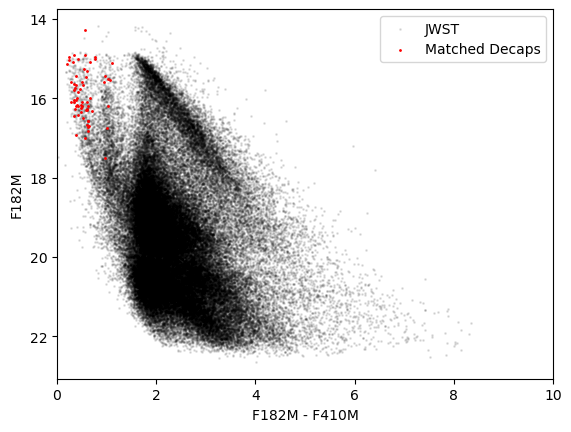

In [11]:
ax = plt.subplot(111)
cat_use.plot_CMD('f182m', 'f410m', 'f182m', color='black', s=1, alpha=0.1, ax=ax, label='JWST')
jwst_merged.plot_CMD('f182m', 'f410m', 'f182m', ax=ax, color='red', s=1, label='Matched Decaps')
ax.set_xlim(0, 10)
plt.gca().invert_yaxis()
ax.legend()

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


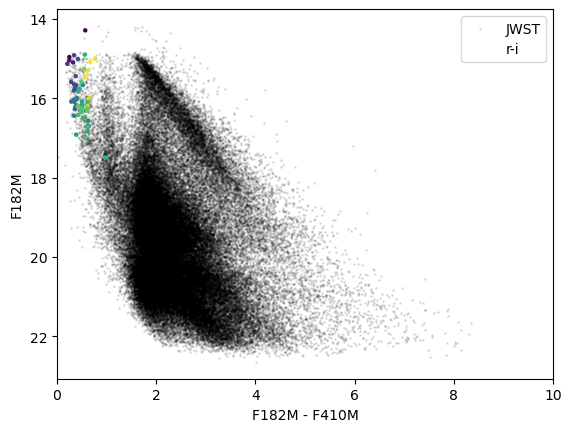

In [16]:
ax = plt.subplot(111)
cat_use.plot_CMD('f182m', 'f410m', 'f182m', color='black', s=1, alpha=0.1, ax=ax, label='JWST')
jwst_merged.plot_CMD('f182m', 'f410m', 'f182m', ax=ax, s=5, label='r-i', c=decaps_merged.color('r', 'i'))
ax.set_xlim(0, 10)
plt.gca().invert_yaxis()
ax.legend()

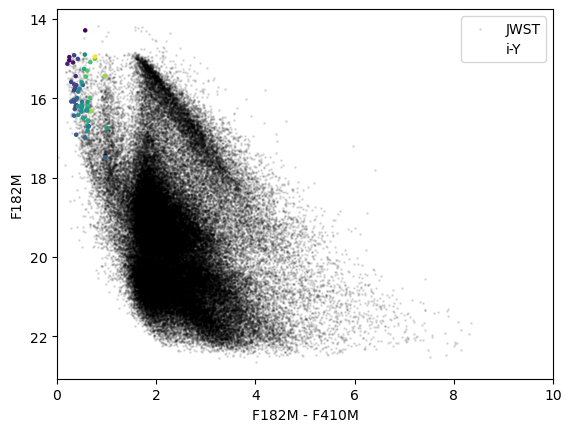

In [17]:
ax = plt.subplot(111)
cat_use.plot_CMD('f182m', 'f410m', 'f182m', color='black', s=1, alpha=0.1, ax=ax, label='JWST')
jwst_merged.plot_CMD('f182m', 'f410m', 'f182m', ax=ax, s=5, label='i-Y', c=decaps_merged.color('i', 'y'))
ax.set_xlim(0, 10)
plt.gca().invert_yaxis()
ax.legend()

<ErrorbarContainer object of 3 artists>

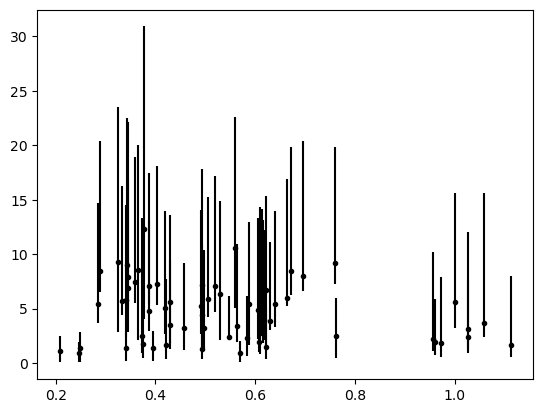

In [14]:
plt.errorbar(jwst_merged.color('f182m', 'f410m'), decaps_merged.catalog['dist'][:, 2], 
             yerr=[decaps_merged.catalog['dist'][:, 1], decaps_merged.catalog['dist'][:, 3]],
             fmt='o', markersize=3, color='k')

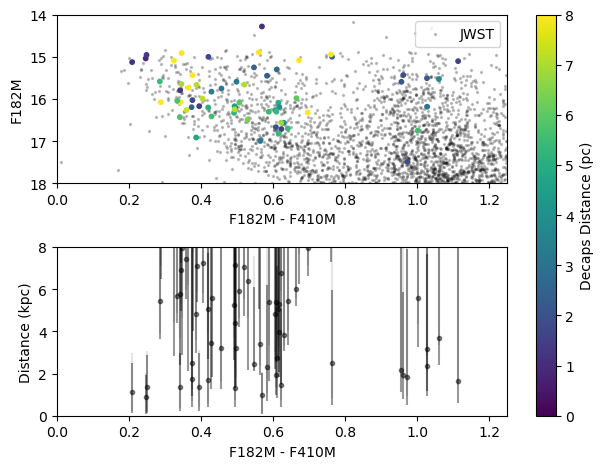

In [33]:
#plt.style.use('dark_background')

ax = plt.subplot(211)
cat_use.plot_CMD('f182m', 'f410m', 'f182m', color='k', s=2, alpha=0.2, ax=ax, label='JWST')
#jwst_merged.plot_CMD('f182m', 'f410m', 'f182m', ax=ax, s=10, label='Distance (pc)', c=decaps_merged.catalog['dist'][:, 2])
im = ax.scatter(jwst_merged.color('f182m', 'f410m'), jwst_merged.band('f182m'), s=10, c=decaps_merged.catalog['dist'][:, 2], cmap='viridis', vmin=0, vmax=8)
ax.set_xlim(0, 1.25)
ax.set_ylim(14, 18)
plt.gca().invert_yaxis()
ax.legend(loc='upper right')

ax1 = plt.subplot(212)
ax1.errorbar(jwst_merged.color('f182m', 'f410m'), decaps_merged.catalog['dist'][:, 2],
            yerr=[decaps_merged.catalog['dist'][:, 1], decaps_merged.catalog['dist'][:, 3]],
            fmt='o', markersize=3, color='k', alpha=0.4)
ax1.errorbar(jwst_merged.color('f182m', 'f410m'), decaps_merged.catalog['dist'][:, 2],
            yerr=[decaps_merged.catalog['dist'][:, 0], decaps_merged.catalog['dist'][:, 4]],
            fmt='o', markersize=3, color='k', alpha=0.1)
ax1.set_xlim(0, 1.25)
ax1.set_ylim(0, 8)
ax1.set_xlabel('F182M - F410M')
ax1.set_ylabel('Distance (kpc)')

plt.tight_layout()
plt.colorbar(im, label='Decaps Distance (pc)', ax=(ax, ax1))


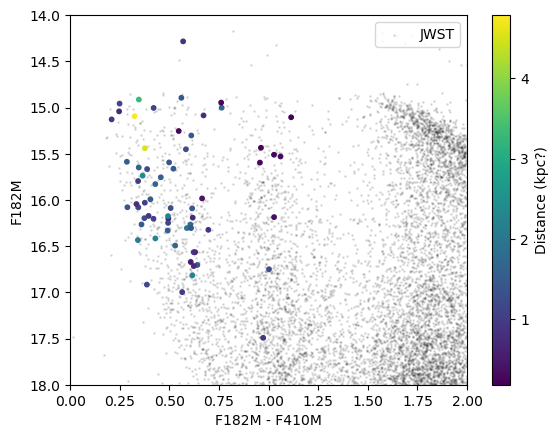

In [ ]:
ax = plt.subplot(111)
cat_use.plot_CMD('f182m', 'f410m', 'f182m', color='black', s=1, alpha=0.1, ax=ax, label='JWST')
#jwst_merged.plot_CMD('f182m', 'f410m', 'f182m', ax=ax, s=10, label='Distance (pc)', c=decaps_merged.catalog['dist'][:, 2])
im = ax.scatter(jwst_merged.color('f182m', 'f410m'), jwst_merged.band('f182m'), s=10, c=decaps_merged.catalog['dist'][:, 0], cmap='viridis')
ax.set_xlim(0, 2)
ax.set_ylim(14, 18)
plt.gca().invert_yaxis()
ax.legend(loc='upper right')
plt.colorbar(im, label='Distance (kpc?)')

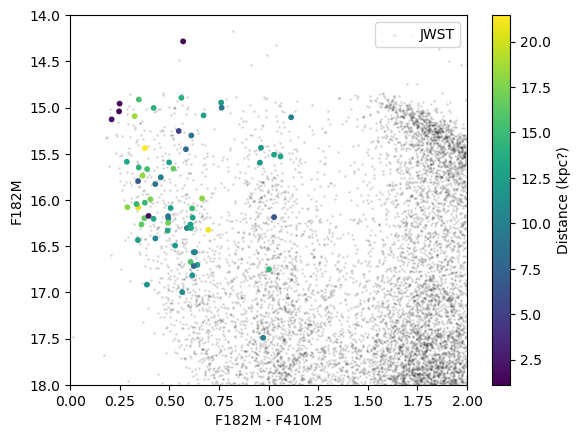

In [120]:
ax = plt.subplot(111)
cat_use.plot_CMD('f182m', 'f410m', 'f182m', color='black', s=1, alpha=0.1, ax=ax, label='JWST')
#jwst_merged.plot_CMD('f182m', 'f410m', 'f182m', ax=ax, s=10, label='Distance (pc)', c=decaps_merged.catalog['dist'][:, 2])
im = ax.scatter(jwst_merged.color('f182m', 'f410m'), jwst_merged.band('f182m'), s=10, c=decaps_merged.catalog['dist'][:, -1], cmap='viridis')
ax.set_xlim(0, 2)
ax.set_ylim(14, 18)
plt.gca().invert_yaxis()
ax.legend(loc='upper right')
plt.colorbar(im, label='Distance (kpc?)')

Text(0, 0.5, 'z')

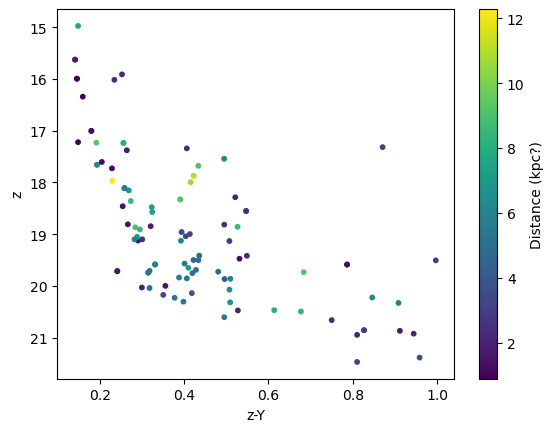

In [130]:
ax = plt.subplot(111)
#cat_use.plot_CMD('f182m', 'f410m', 'f182m', color='black', s=1, alpha=0.1, ax=ax, label='JWST')
#decaps_merged.plot_CMD('z', 'y', 'z', ax=ax, s=10, c=decaps_merged.catalog['dist'][:, 2])
im = ax.scatter(decaps_merged.color('z', 'y'), decaps_merged.band('z'), s=10, c=decaps_merged.catalog['dist'][:, 2], cmap='viridis')
#jwst_merged.plot_CMD('f182m', 'f410m', 'f182m', ax=ax, s=10, label='Distance (pc)', c=decaps_merged.catalog['dist'][:, 2])
#im = ax.scatter(jwst_merged.color('f182m', 'f410m'), jwst_merged.band('f182m'), s=10, c=decaps_merged.catalog['dist'][:, 2], cmap='viridis', vmax=8)
#ax.set_xlim(0, 2)
#ax.set_ylim(14, 18)
plt.gca().invert_yaxis()
#ax.legend(loc='upper right')
plt.colorbar(im, label='Distance (kpc?)')
ax.set_xlabel('z-Y')
ax.set_ylabel('z')

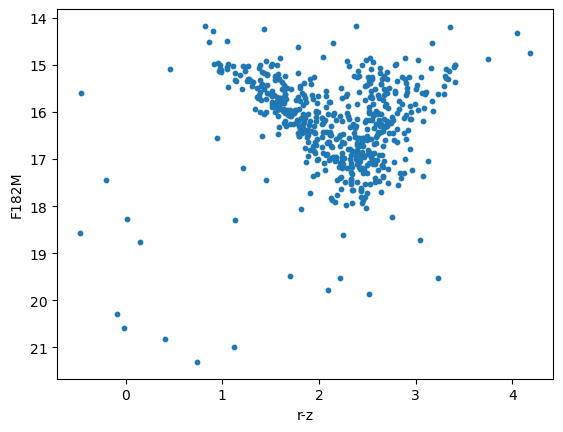

In [26]:
plt.scatter(decaps_merged.color('r', 'z'), jwst_merged.band('f182m'), s=10)
plt.xlabel('r-z')
plt.ylabel('F182M')
plt.gca().invert_yaxis()

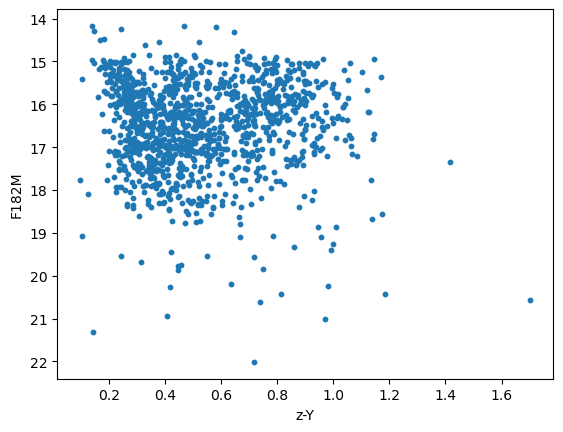

In [27]:
plt.scatter(decaps_merged.color('z', 'y'), jwst_merged.band('f182m'), s=10)
plt.xlabel('z-Y')
plt.ylabel('F182M')
plt.gca().invert_yaxis()

Text(0, 0.5, 'g-r')

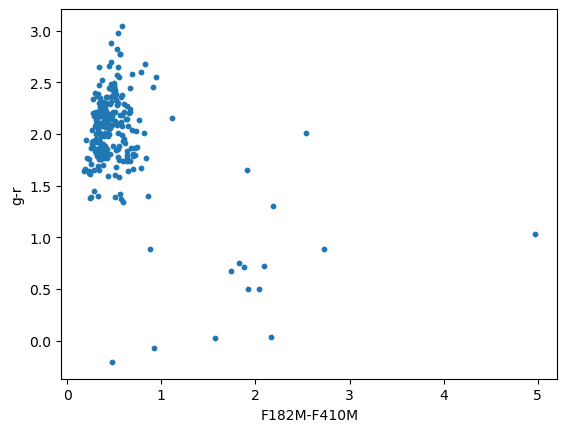

In [28]:
plt.scatter(jwst_merged.color('f182m', 'f410m'), decaps_merged.color('g', 'r'), s=10)
plt.xlabel('F182M-F410M')
plt.ylabel('g-r')


Text(0, 0.5, 'r-i')

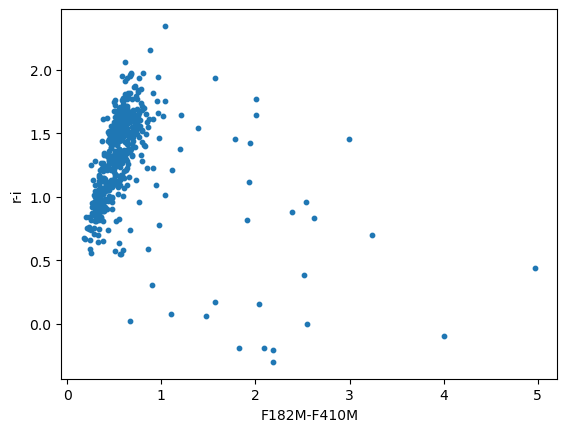

In [29]:
plt.scatter(jwst_merged.color('f182m', 'f410m'), decaps_merged.color('r', 'i'), s=10)
plt.xlabel('F182M-F410M')
plt.ylabel('r-i')


Text(0, 0.5, 'r-i')

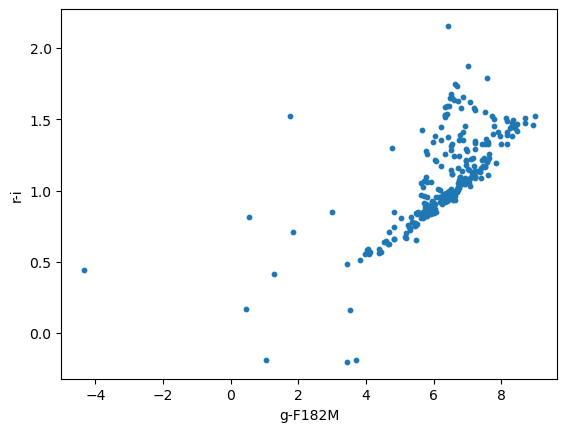

In [30]:
plt.scatter(decaps_merged.band('g')-jwst_merged.band('f182m'), decaps_merged.color('r', 'i'), s=10)
plt.xlabel('g-F182M')
plt.ylabel('r-i')


Text(0, 0.5, 'Y-F410M')

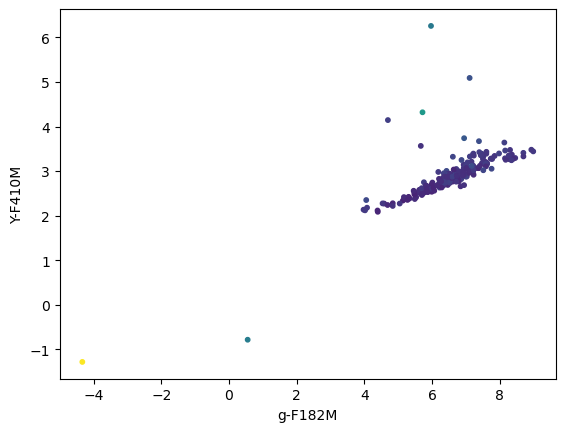

In [31]:
plt.scatter(decaps_merged.band('g')-jwst_merged.band('f182m'), decaps_merged.band('y')-jwst_merged.band('f410m'), s=10, c=jwst_merged.color('f182m', 'f410m'))
plt.xlabel('g-F182M')
plt.ylabel('Y-F410M')


Text(0, 0.5, 'Y-F182M')

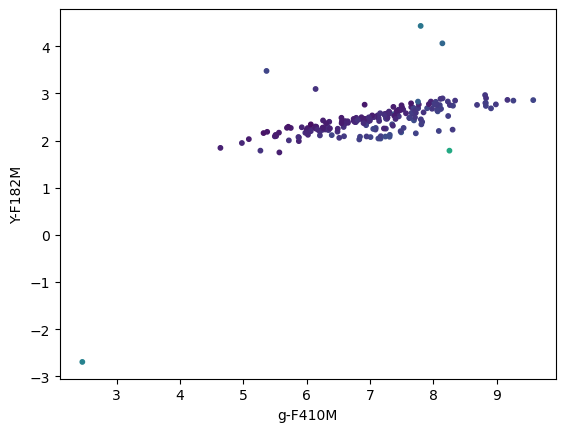

In [65]:
plt.scatter(decaps_merged.band('g')-jwst_merged.band('f410m'), decaps_merged.band('y')-jwst_merged.band('f182m'), s=10, c=jwst_merged.color('f212n', 'f466n'))
plt.xlabel('g-F410M')
plt.ylabel('Y-F182M')


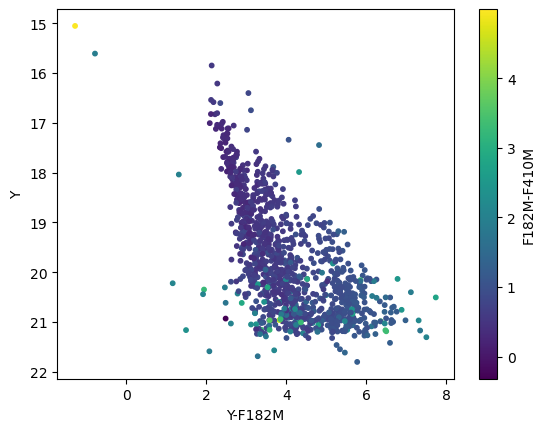

In [77]:
im = plt.scatter(decaps_merged.band('y')-jwst_merged.band('f410m'), decaps_merged.band('y'), s=10, c=jwst_merged.color('f182m', 'f410m'))#, vmin=0, vmax=2)
plt.xlabel('Y-F182M')
plt.ylabel('Y')
plt.gca().invert_yaxis()
plt.colorbar(im, label='F182M-F410M')

## Filament Region

In [57]:
reg_fov = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/f4_fov_cloudc.reg')
#decaps_fov = decaps_cat.catalog[reg_fov[0].contains(decaps_catalog, wcs=WCS(im_filt.header))]

matched_decaps = Table.read('/orange/adamginsburg/jwst/cloudc/catalogs/only_matched_decaps.fits')
matched_decaps_filament = matched_decaps[reg_filabox.contains(matched_decaps['skycoord_ref'], wcs=WCS(im_filt.header))]
decaps_merged_filament = DecapsCatalog(matched_decaps_filament)
jwst_merged_filament = JWSTCatalog(matched_decaps_filament)

cat_use = make_cat_use()
cat_use_filament = cat_use.catalog[reg_filabox.contains(cat_use.catalog['skycoord_ref'], wcs=WCS(im_filt.header))]
cat_use_filament = JWSTCatalog(cat_use_filament)

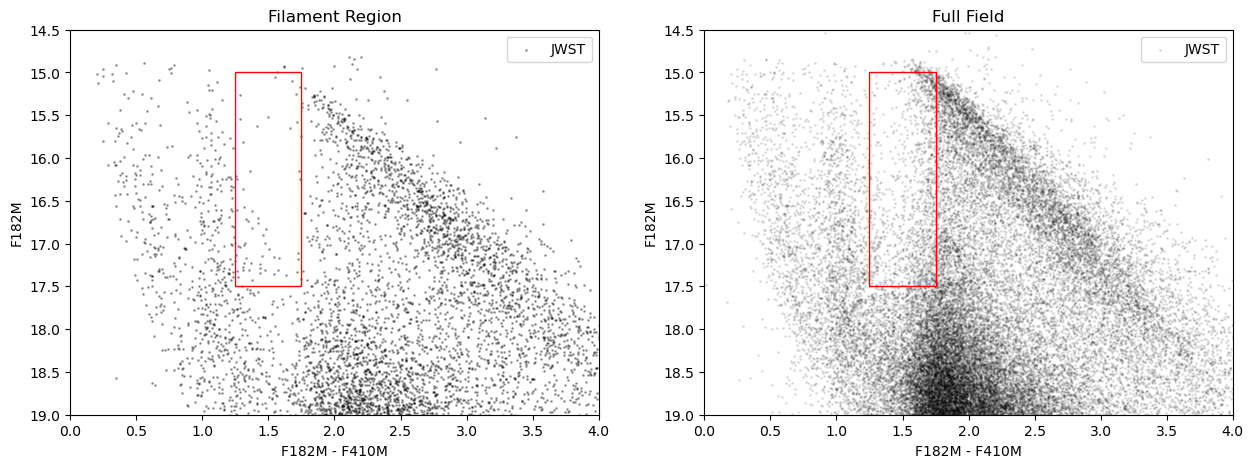

In [88]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(121)
cat_use_filament.plot_CMD('f182m', 'f410m', 'f182m', s=1, color='k', alpha=0.3, ax=ax, label='JWST')
#jwst_merged_filament.plot_CMD('f182m', 'f410m', 'f182m', s=10, c=decaps_merged_filament.color('r', 'i'), ax=ax, label='Matched Decaps')

rect = plt.Rectangle((1.25, 15), 0.5, 2.5, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.gca().invert_yaxis()
ax.set_xlim(0, 4)
ax.set_ylim(19, 14.5)
ax.set_title('Filament Region')
ax.legend()

ax2 = plt.subplot(122)
cat_use.plot_CMD('f182m', 'f410m', 'f182m', s=1, color='k', alpha=0.1, ax=ax2, label='JWST')
#jwst_merged.plot_CMD('f182m', 'f410m', 'f182m', s=5, c=decaps_merged.color('r', 'i'), ax=ax2, label='Matched Decaps')
rect = plt.Rectangle((1.25, 15), 0.5, 2.5, linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

plt.gca().invert_yaxis()
ax2.set_xlim(0, 4)
ax2.set_ylim(19, 14.5)
ax2.set_title('Full Field')
ax2.legend()

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


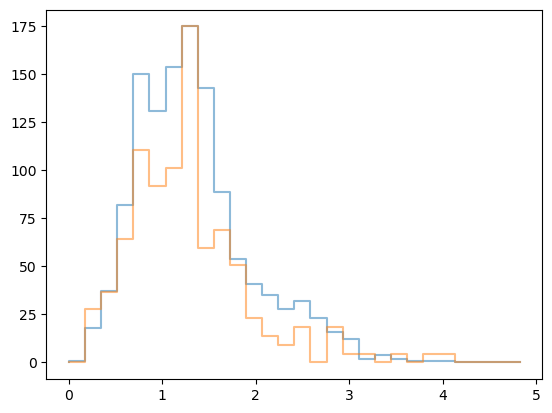

In [59]:
color_iy = decaps_merged.color('i', 'y')
color_iy[color_iy > 1e12] = np.nan
color_iy[color_iy < -1e12] = np.nan
color_iy_filament = decaps_merged_filament.color('i', 'y')
color_iy_filament[color_iy_filament > 1e12] = np.nan
color_iy_filament[color_iy_filament < -1e12] = np.nan
np.nanmax(color_iy), np.nanmin(color_iy)
bins = np.linspace(0, 5, 30)
h = np.histogram(color_iy, bins=bins)
h_fil = np.histogram(color_iy_filament, bins=bins)
plt.step(h[1][:-1], h[0], alpha=0.5)
plt.step(h_fil[1][:-1], h_fil[0]*np.max(h[0])/np.max(h_fil[0]), alpha=0.5)